# Preliminaries

Set up taken from rnn_notebook demo from week 8

See here: https://colab.research.google.com/drive/1whCpnoUGoB1FhpaxQTfLDdAzB7yMvkgE 

In [ ]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import torchvision.datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pdb
import math

Mount Google Drive (taken from A2):

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


We will work with the ETFs folder since it has less data, and we will seperate one file path in particular to have a closer look at it

In [ ]:
etf_path = "/content/gdrive/My Drive/CSC413FinalProject/data/unzipped/ETFs/"
stock_path = "/content/gdrive/My Drive/CSC413FinalProject/data/unzipped/Stocks/"

smalldata_path = "/content/gdrive/My Drive/CSC413FinalProject/data/unzipped/smallDataSet/"

somedata_path = "/content/gdrive/My Drive/CSC413FinalProject/data/unzipped/ETFs/aadr.us.txt"

In [ ]:
# file_paths: the google drive directory to retrieve the data from
# num_days: the number of days into the future we will make predictions for
# cols: Feed in array of form ["Close", ...] with the column headers for the data you want to extract 

def init_data(file_paths, num_days, cols):
  data = []

                         
  for path in file_paths:
    for filename in os.listdir(path):
        f = os.path.join(path, filename)
        if os.path.getsize(f) > 0:       
          # Extract data from only 2016 onwards
          df = pd.read_csv(f, parse_dates = True)

          mask = df['Date'] >= "2016-01-01" 

          data.append(
                      (
                       torch.tensor(df.loc[mask][cols].to_numpy()[:-num_days]),
                       torch.tensor(df.loc[mask][cols].to_numpy()[-num_days:])
                      )
                     )
            
  return data

In [ ]:
dataset = init_data([stock_path, etf_path], 1, ["Close"])

In [ ]:
print(len(dataset))

for i in range(len(dataset)):
  if i > 5:
    break
  print(len(dataset[i][0]))
  

8507
469
469
374
469
469
45


In [ ]:
smalldataset = init_data([smalldata_path], 1, ["Close"])
total = 0
t = 0
for d in smalldataset:
  print(len(d[0]), len(d[1]))
  total += len(d[0])
  t+=1
print(t)
# print(smalldataset[0])
# print(smalldataset[1])

469 1
469 1
469 1
469 1
469 1
469 1
469 1
459 1
469 1
151 1
10


#Divide data into train, validation, test

Shuffles the data array and makes a 60, 20, 20 split of the data into training, validation, and test set

In [ ]:
# Divides the data into training, validation, test, with 60%, 20%, 20% split

def divide_data(data, shuffle_seed=31415926):
  train = []
  valid = []
  test = []
  
  rng = np.random.RandomState(shuffle_seed)
  perm = rng.permutation(len(data))
  
  for i in range(len(data)):
    if i % 5 < 3:
      train.append(data[perm[i]])
    elif i % 5 == 3:
      valid.append(data[perm[i]])
    else:
      test.append(data[perm[i]])

  return train, valid, test


In [ ]:
train, valid, test = divide_data(dataset)

In [ ]:
print(len(train))
print(len(valid))
print(len(test))

5105
1701
1701


In [ ]:
for i in range(len(train)):
  if i > 5:
    break
  print(train[i])
  print(train[i][0].shape)
  print(train[i][1].shape)

(tensor([[35.8030],
        [35.8750],
        [35.4490],
        [34.8300],
        [34.1690],
        [34.5940],
        [34.6820],
        [33.5800],
        [33.6500],
        [32.9120],
        [32.9420],
        [32.8430],
        [33.3840],
        [33.0260],
        [33.3710],
        [33.2070],
        [33.3510],
        [33.9440],
        [34.3920],
        [33.8800],
        [33.5800],
        [33.1090],
        [32.0550],
        [31.5830],
        [31.6420],
        [31.9090],
        [31.6330],
        [32.3030],
        [32.9120],
        [33.4630],
        [33.0690],
        [33.1520],
        [33.4730],
        [33.7000],
        [33.7660],
        [34.3870],
        [34.8420],
        [34.9530],
        [34.7010],
        [35.1840],
        [34.9100],
        [35.0650],
        [35.0940],
        [35.0850],
        [35.5280],
        [35.7920],
        [35.6940],
        [35.8620],
        [36.1570],
        [36.5300],
        [36.4420],
        [36.3430],
        [36

# Data Augmentation

After having discussions with our TA, we determined that having 10,000 total data points is necessary. Thus, since our dataset originally had only 8,500 datapoints (sequences), we will add an additional 1,500 datapoints. To do this, we pick a random 1,500 datapoints from training, and random "gaussian noise" to these values and add them to the training set.

In [ ]:
# Create copy of training set 
train_copy = train.copy()

rng = np.random.RandomState(31415926)
# Add Random Noise to the data within train_copy
for data, labels in train_copy:
  myDataNoise = rng.normal(loc=0, 
                           scale=0.3, 
                           size=(data.shape[0], data.shape[1]))
  
  myLabelNoise = rng.normal(loc=0, 
                            scale=0.3, 
                            size=(labels.shape[0], labels.shape[1]))

  data += myDataNoise
  labels += myLabelNoise

# Pick a random selection of these points to include in the training set
# Note: Change size to produce more random points 
# Picking 1500 so that we have 10000 total points 
rnd_array = np.random.randint(len(train), size=1500)

for i in rnd_array:
  train.append(train_copy[i])

print(len(train))

6605


#Batch Data by length

Will use batching to combat the use of padding and improve runtime (using same idea from Tweet Sentiment Analysis tutorial from class). We batch together sequences of stock data that contain the same amount of data (are the same length).

In [ ]:
import random

class StockBatcher:
    def __init__(self, stocks, batch_size=128, drop_last=False):
        # store stocks by length
        self.stock_by_length = {}
        for stock_data, label in stocks:
            # compute the length of the stock_data
            slen = stock_data.shape[0]
            # Do not consider empty datapoints
            if slen == 0:
              continue
            # put the stock in the correct key inside self.stock_by_length
            if slen not in self.stock_by_length:
                self.stock_by_length[slen] = []
            self.stock_by_length[slen].append((stock_data.float(), 
                                               label.float()))
         
        #  create a DataLoader for each set of stocks with the same amount of data
        self.loaders = {slen : torch.utils.data.DataLoader(
                                    stock_data,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for slen, stock_data in self.stock_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

Taking a look at the stock batcher data, to get a feel for the format of the data 

In [ ]:
for i, (stock_data, labels) in enumerate(StockBatcher(train, drop_last=False)):
    print(stock_data.shape, labels.shape)

torch.Size([1, 396, 1]) torch.Size([1, 1, 1])
torch.Size([6, 329, 1]) torch.Size([6, 1, 1])
torch.Size([10, 2, 1]) torch.Size([10, 1, 1])
torch.Size([4, 302, 1]) torch.Size([4, 1, 1])
torch.Size([7, 449, 1]) torch.Size([7, 1, 1])
torch.Size([4, 151, 1]) torch.Size([4, 1, 1])
torch.Size([2, 349, 1]) torch.Size([2, 1, 1])
torch.Size([2, 265, 1]) torch.Size([2, 1, 1])
torch.Size([3, 308, 1]) torch.Size([3, 1, 1])
torch.Size([3, 48, 1]) torch.Size([3, 1, 1])
torch.Size([9, 6, 1]) torch.Size([9, 1, 1])
torch.Size([2, 348, 1]) torch.Size([2, 1, 1])
torch.Size([38, 463, 1]) torch.Size([38, 1, 1])
torch.Size([7, 21, 1]) torch.Size([7, 1, 1])
torch.Size([5, 45, 1]) torch.Size([5, 1, 1])
torch.Size([1, 243, 1]) torch.Size([1, 1, 1])
torch.Size([22, 456, 1]) torch.Size([22, 1, 1])
torch.Size([3, 261, 1]) torch.Size([3, 1, 1])
torch.Size([37, 465, 1]) torch.Size([37, 1, 1])
torch.Size([1, 104, 1]) torch.Size([1, 1, 1])
torch.Size([2, 173, 1]) torch.Size([2, 1, 1])
torch.Size([1, 36, 1]) torch.Size

# Model

We have implemented an RNN utilizing GRU units that consists of 1 layer  

In [ ]:
class StockPredictGRU(nn.Module):
  def __init__(self, 
               input_size=1, 
               hidden_size=128, 
               num_layers=1,
               output_size=1):
    super(StockPredictGRU, self).__init__()
    self.hidden_size = hidden_size
    # batch_first = True so that the layer knows that the input format is
    # [batch_size, seq_len, repr_dim] -- in general case
    # [n = ?, l = ?, in = 1] -- in our case
    # Note: nn.GRU returns two values: the output and final hidden state
    self.gru = nn.GRU(input_size, 
                      hidden_size, 
                      num_layers,
                      batch_first = True) 
    self.fc = nn.Linear(hidden_size, 
                        output_size)

  def forward(self, x, hidden = None):
    # The initial hidden state is set to all zeros by default
    # every time-step after should have an input for hidden to make future pred.
    output, hidden = self.gru(x, hidden) # forward propogate the GRU
    # Pass the output of the last time step to the FC layer
    output = self.fc(output[:, -1, :])
    return output, hidden

## Training Code:
Decisions to be made about train() implementation:
- The plan is to train the model to predict the next value over, so teach it to predict the n+1 element (n being the sequence length)

#### Loss Function: **Mean Squared Loss**

* Since we have a regression problem the mean squared loss function might be the best choice.

#### Optimizer: **Adam**

* Effective and Efficient Optimizer

#### Checkpointing:

* Will be useful for cutting training time and building off of existing weights.

#### After each epoch the costs of both the training and validation sets will be recorded.

* Will also plot the training curve to get an overview of how the training was being conducted.

In [ ]:
def train_rnn_network(model, train, valid, num_epochs=100, learning_rate=0.01, 
                      weight_decay = 0, checkpoint_path=None):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                                 weight_decay=weight_decay)
  losses, train_cost, valid_cost = [], [], []
  epochs = []
  iterations = 0
  for epoch in range(num_epochs):
    for stock_data, labels in train:
      model.train()
      iterations += 1
      optimizer.zero_grad()
      pred, _ = model(stock_data)
      loss = criterion(pred, labels.reshape(pred.shape[0], pred.shape[1]))
      loss.backward()
      optimizer.step()

    losses.append(float(loss))
    epochs.append(epoch)
    train_cost.append(get_cost(model, train))
    valid_cost.append(get_cost(model, valid))
    print("Epoch %d; Iteration %d; Loss %f; Train Cost %f; Val Cost %f" % (
            epoch+1, iterations, loss, train_cost[-1], valid_cost[-1]))

    if checkpoint_path is not None:
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': train_cost[-1]
                        }, checkpoint_path.format(iterations))
          
    
  # plotting
  plt.title("Learning Curve")
  plt.plot(losses, label="Train")
  plt.xlabel("Epoch")
  plt.ylabel("Cost")
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_cost, label="Train")
  plt.plot(epochs, valid_cost, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Cost")
  plt.legend(loc='best')
  plt.show()

# Finding an Alternative to Accuracy: 

## Cost 

- The fact that we have somewhat of a regression problem makes having an "accuracy function" pointless
- Alternative would be to have a cost function

In [ ]:
def get_cost(model, data):
  loss_function = nn.MSELoss()
  loss = 0
  total = 0

  for stock_data, labels in data:
    output, _ = model(stock_data)
    # Calculate the MSE and add it to total loss
    loss += loss_function(output, 
                          labels.reshape(output.shape[0], output.shape[1])).item()
    # Divide by number of stock_data points
    total += stock_data.shape[0]

  return loss/total

# Performing the Training (including overfitting on small dataset)

Epoch 1; Loss 1583.770020; Train Loss 16747.753586; Val Loss 65.897919
Epoch 2; Loss 546.688843; Train Loss 14079.870663; Val Loss 84.519079
Epoch 3; Loss 306.951233; Train Loss 11546.965611; Val Loss 229.634690
Epoch 4; Loss 141.609985; Train Loss 9499.199552; Val Loss 490.045052
Epoch 5; Loss 2926.108154; Train Loss 8085.053240; Val Loss 808.703293
Epoch 6; Loss 4348.474121; Train Loss 7086.119765; Val Loss 1152.996002
Epoch 7; Loss 3842.825928; Train Loss 6341.975755; Val Loss 1528.851379
Epoch 8; Loss 403.531860; Train Loss 5776.699789; Val Loss 1940.860291
Epoch 9; Loss 67.550674; Train Loss 5441.135963; Val Loss 2254.784485
Epoch 10; Loss 2846.758301; Train Loss 5263.677499; Val Loss 2321.613464
Epoch 11; Loss 1336.581299; Train Loss 5055.189212; Val Loss 2381.367004
Epoch 12; Loss 1.191421; Train Loss 4909.451384; Val Loss 2510.991516
Epoch 13; Loss 1.680599; Train Loss 4863.114808; Val Loss 2572.789612
Epoch 14; Loss 1093.295410; Train Loss 4784.187931; Val Loss 2602.795471
Epo

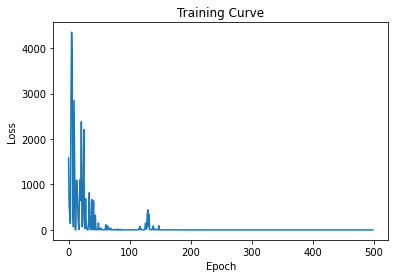

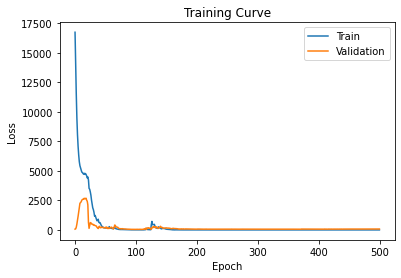

In [ ]:
# Initialize Model
model = StockPredictGRU()

# Perform a split on the small_dataset as well
sm_train, sm_valid, sm_test = divide_data(smalldataset)

sm_train_loader = StockBatcher(sm_train, batch_size= 1, drop_last=False)
sm_valid_loader = StockBatcher(sm_valid, batch_size= 1, drop_last=False)

# Overfit on small dataset 
train_rnn_network(model, sm_train_loader, sm_valid_loader, num_epochs=500)

Maham Training

Here is the first training run, using default hyper parameter choices 

Epoch 1; Iteration 453; Loss 789.206726; Train Cost 38551.502197; Val Cost 339.839523
Epoch 2; Iteration 906; Loss 588.274780; Train Cost 38536.497083; Val Cost 291.000959
Epoch 3; Iteration 1359; Loss 1887.537476; Train Cost 38557.959318; Val Cost 345.884667
Epoch 4; Iteration 1812; Loss 151511.328125; Train Cost 38608.363089; Val Cost 523.613654
Epoch 5; Iteration 2265; Loss 1118.515137; Train Cost 38585.205343; Val Cost 433.401996
Epoch 6; Iteration 2718; Loss 696.411682; Train Cost 38536.837156; Val Cost 289.711277
Epoch 7; Iteration 3171; Loss 1694.158325; Train Cost 38636.204011; Val Cost 601.824719
Epoch 8; Iteration 3624; Loss 1928.826294; Train Cost 38644.781564; Val Cost 591.119013
Epoch 9; Iteration 4077; Loss 13893.999023; Train Cost 38623.943166; Val Cost 532.975603
Epoch 10; Iteration 4530; Loss 2615.634521; Train Cost 38640.457686; Val Cost 621.194703
Epoch 11; Iteration 4983; Loss 2077.883057; Train Cost 38624.957883; Val Cost 572.707605
Epoch 12; Iteration 5436; Loss 2

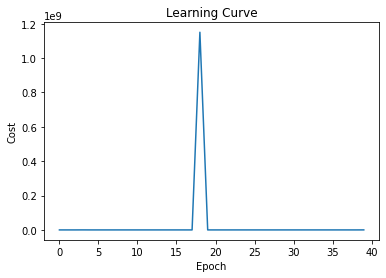

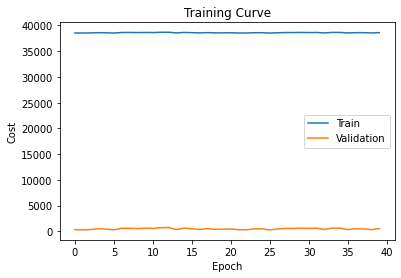

In [ ]:
model1 = StockPredictGRU() 
# Initialize training and validation batches 
train_loader = StockBatcher(train, batch_size=300, drop_last=False)
valid_loader = StockBatcher(valid, batch_size=300, drop_last=False)

train_rnn_network(model1, train_loader, valid_loader, weight_decay=0.0, learning_rate=0.1, num_epochs=40)

Second training run, increased weight decay, decreased learning rate to reduce fluctuations.

Epoch 1; Iteration 453; Loss 0.528757; Train Cost 169328.295378; Val Cost 240.907101
Epoch 2; Iteration 906; Loss 502.244843; Train Cost 76889.521144; Val Cost 241.269342
Epoch 3; Iteration 1359; Loss 425.357025; Train Cost 76877.465221; Val Cost 227.869557
Epoch 4; Iteration 1812; Loss 861.351990; Train Cost 76875.771002; Val Cost 224.755693
Epoch 5; Iteration 2265; Loss 1912.194092; Train Cost 76875.248851; Val Cost 228.264231
Epoch 6; Iteration 2718; Loss 300.101196; Train Cost 76864.866192; Val Cost 221.429943
Epoch 7; Iteration 3171; Loss 364.813904; Train Cost 76887.164061; Val Cost 234.519004
Epoch 8; Iteration 3624; Loss 1430.421021; Train Cost 76904.998194; Val Cost 228.988458
Epoch 9; Iteration 4077; Loss 91.781174; Train Cost 76900.938629; Val Cost 229.250957
Epoch 10; Iteration 4530; Loss 11694.152344; Train Cost 76863.771828; Val Cost 219.268567
Epoch 11; Iteration 4983; Loss 145.071518; Train Cost 76853.373256; Val Cost 206.533886
Epoch 12; Iteration 5436; Loss 170.735535

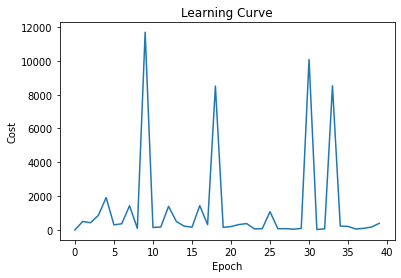

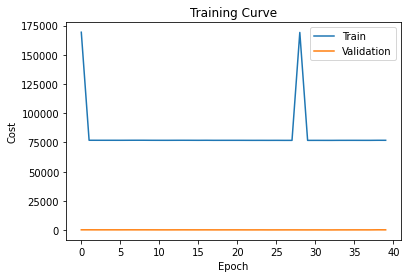

In [ ]:
model2 = StockPredictGRU() 
# Initialize training and validation batches 
train_loader = StockBatcher(train, batch_size=300, drop_last=False)
valid_loader = StockBatcher(valid, batch_size=300, drop_last=False)

train_rnn_network(model2, train_loader, valid_loader, weight_decay=0.01, learning_rate=0.01, num_epochs=40)

Third training run, increased batch size, reduced epochs, removed weight decay. To decrease variance

Epoch 1; Iteration 447; Loss 544.619080; Train Cost 23185.387694; Val Cost 281.402192
Epoch 2; Iteration 894; Loss 3.401223; Train Cost 23165.382848; Val Cost 235.670053
Epoch 3; Iteration 1341; Loss 3.989877; Train Cost 43411.963184; Val Cost 223.621297
Epoch 4; Iteration 1788; Loss 285478528.000000; Train Cost 23164.527857; Val Cost 237.364861
Epoch 5; Iteration 2235; Loss 3.692450; Train Cost 23159.486725; Val Cost 222.341236
Epoch 6; Iteration 2682; Loss 504.832001; Train Cost 23158.921699; Val Cost 236.204860
Epoch 7; Iteration 3129; Loss 41811.003906; Train Cost 23152.906040; Val Cost 214.632494
Epoch 8; Iteration 3576; Loss 3476.242676; Train Cost 23148.682148; Val Cost 204.702134
Epoch 9; Iteration 4023; Loss 4416.174316; Train Cost 23146.042879; Val Cost 205.919014
Epoch 10; Iteration 4470; Loss 469.536804; Train Cost 23137.486671; Val Cost 198.414089
Epoch 11; Iteration 4917; Loss 402.019836; Train Cost 23137.814889; Val Cost 206.544145
Epoch 12; Iteration 5364; Loss 243.8979

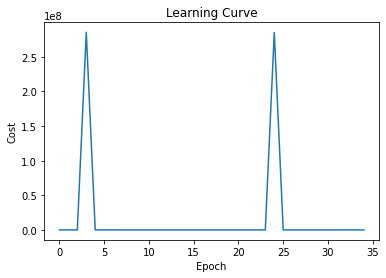

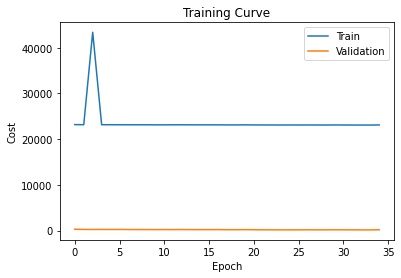

In [ ]:
model3 = StockPredictGRU() 
# Initialize training and validation batches 
train_loader = StockBatcher(train, batch_size=500, drop_last=False)
valid_loader = StockBatcher(valid, batch_size=500, drop_last=False)

train_rnn_network(model3, train_loader, valid_loader, weight_decay=0.0, learning_rate=0.01, num_epochs=35)

Here's the second training run, decreased batch size, added weight decay,  

Mac Training

For the next 3 sets of training runs, experimented with a smaller learning rate and varied the value for weight decay. First we used $5\times10^{-4}$. 

Epoch 1; Iteration 445; Loss 2214.310547; Train Cost 30029.734195; Val Cost 328.481722
Epoch 2; Iteration 890; Loss 59069.589844; Train Cost 30014.593183; Val Cost 298.865638
Epoch 3; Iteration 1335; Loss 36391.789062; Train Cost 49695.167514; Val Cost 277.555205
Epoch 4; Iteration 1780; Loss 30.602365; Train Cost 29991.061082; Val Cost 266.575729
Epoch 5; Iteration 2225; Loss 0.007248; Train Cost 29984.288496; Val Cost 256.157176
Epoch 6; Iteration 2670; Loss 57442.265625; Train Cost 29978.241486; Val Cost 253.851584
Epoch 7; Iteration 3115; Loss 699.238342; Train Cost 29973.679942; Val Cost 259.200698
Epoch 8; Iteration 3560; Loss 1028.793823; Train Cost 29972.113834; Val Cost 234.573792
Epoch 9; Iteration 4005; Loss 4159.569824; Train Cost 29966.352762; Val Cost 240.167978
Epoch 10; Iteration 4450; Loss 659.599792; Train Cost 29961.679147; Val Cost 233.586174
Epoch 11; Iteration 4895; Loss 1.288036; Train Cost 29962.262395; Val Cost 228.724117
Epoch 12; Iteration 5340; Loss 878.5768

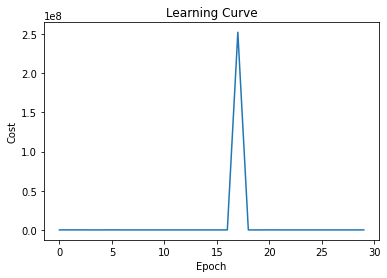

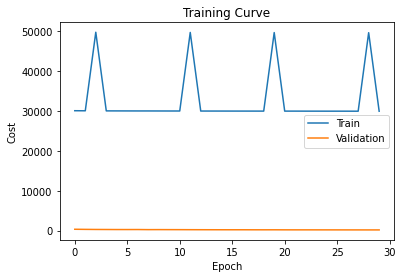

In [ ]:
model4 = StockPredictGRU() 
# Initialize training and validation batches 
train_loader = StockBatcher(train, batch_size=500, drop_last=False)
valid_loader = StockBatcher(valid, batch_size=500, drop_last=False)

train_rnn_network(model4, train_loader, valid_loader, weight_decay=5*(10**(-4)), learning_rate=0.001, num_epochs=30)

Kept learning rate from previous one, changed weight decay to 0.

Epoch 1; Iteration 445; Loss 3.862795; Train Cost 30038.728191; Val Cost 337.112597
Epoch 2; Iteration 890; Loss 1301.302124; Train Cost 30015.774751; Val Cost 304.311358
Epoch 3; Iteration 1335; Loss 0.032888; Train Cost 30000.893953; Val Cost 298.728530
Epoch 4; Iteration 1780; Loss 0.082459; Train Cost 29992.718483; Val Cost 268.995021
Epoch 5; Iteration 2225; Loss 0.018141; Train Cost 29990.927183; Val Cost 258.606545
Epoch 6; Iteration 2670; Loss 0.040800; Train Cost 29980.827747; Val Cost 250.568082
Epoch 7; Iteration 3115; Loss 1079.681396; Train Cost 29975.454392; Val Cost 243.220980
Epoch 8; Iteration 3560; Loss 6304.453125; Train Cost 49667.856853; Val Cost 237.833730
Epoch 9; Iteration 4005; Loss 0.223532; Train Cost 29969.070892; Val Cost 231.475644
Epoch 10; Iteration 4450; Loss 1.421142; Train Cost 29963.336521; Val Cost 226.098501
Epoch 11; Iteration 4895; Loss 887.299927; Train Cost 29959.845134; Val Cost 222.447847
Epoch 12; Iteration 5340; Loss 0.002169; Train Cost 29

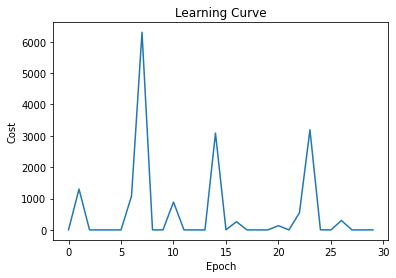

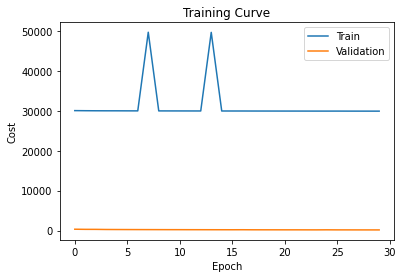

In [ ]:
model5 = StockPredictGRU() 
# Initialize training and validation batches 
train_loader = StockBatcher(train, batch_size=500, drop_last=False)
valid_loader = StockBatcher(valid, batch_size=500, drop_last=False)

train_rnn_network(model5, train_loader, valid_loader, weight_decay=0, learning_rate=0.001, num_epochs=30)

Changed the weight decay to $5\times10^{-3}$

Epoch 1; Iteration 445; Loss 902.137268; Train Cost 30029.861025; Val Cost 330.187828
Epoch 2; Iteration 890; Loss 0.239042; Train Cost 30012.377227; Val Cost 299.831699
Epoch 3; Iteration 1335; Loss 846.572937; Train Cost 30001.566895; Val Cost 282.644320
Epoch 4; Iteration 1780; Loss 0.150965; Train Cost 29991.683229; Val Cost 267.087240
Epoch 5; Iteration 2225; Loss 0.004648; Train Cost 29985.486534; Val Cost 259.984632
Epoch 6; Iteration 2670; Loss 1297.093384; Train Cost 29980.711316; Val Cost 267.035189
Epoch 7; Iteration 3115; Loss 0.131336; Train Cost 29975.184483; Val Cost 264.845648
Epoch 8; Iteration 3560; Loss 0.373291; Train Cost 29971.227793; Val Cost 236.680129
Epoch 9; Iteration 4005; Loss 340.335999; Train Cost 29966.921754; Val Cost 231.229962
Epoch 10; Iteration 4450; Loss 1.417768; Train Cost 29962.132803; Val Cost 224.141969
Epoch 11; Iteration 4895; Loss 3533.397461; Train Cost 29961.897996; Val Cost 221.674668
Epoch 12; Iteration 5340; Loss 252244736.000000; Trai

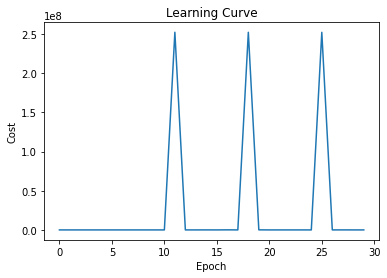

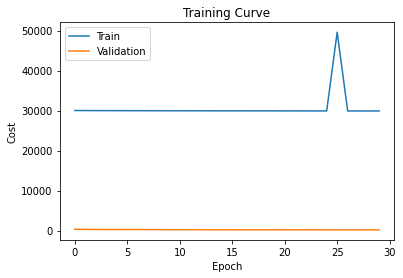

In [ ]:
model6 = StockPredictGRU() 
# Initialize training and validation batches 
train_loader = StockBatcher(train, batch_size=500, drop_last=False)
valid_loader = StockBatcher(valid, batch_size=500, drop_last=False)

train_rnn_network(model6, train_loader, valid_loader, weight_decay=5*(10**(-3)), learning_rate=0.001, num_epochs=30)

# Model Test Set Evaluation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


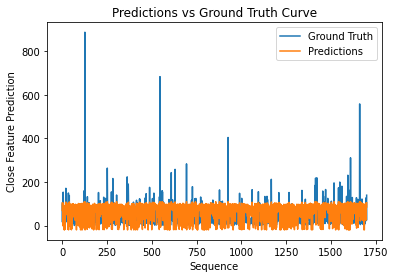

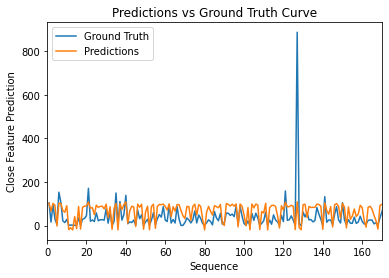

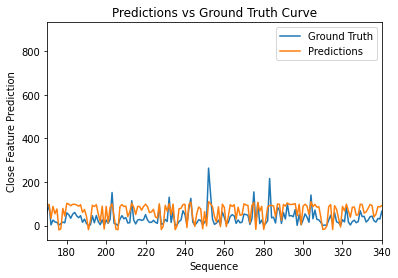

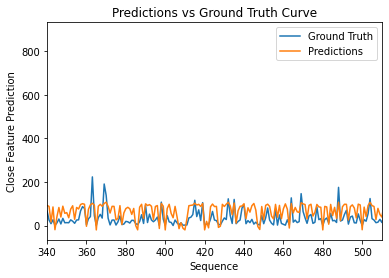

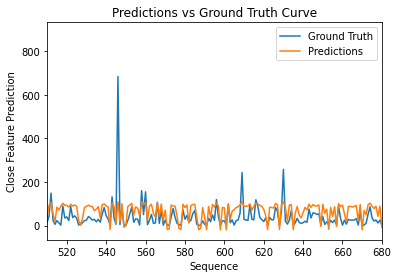

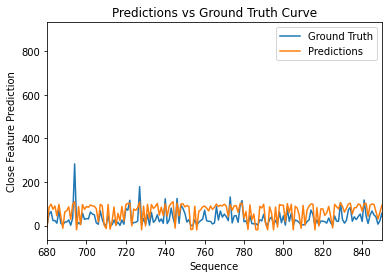

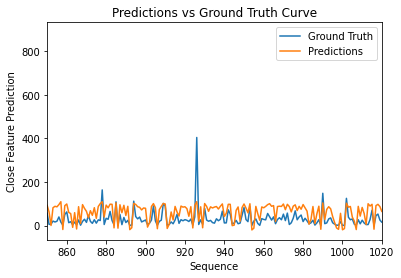

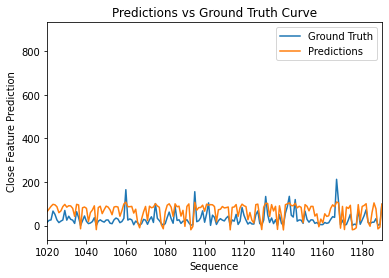

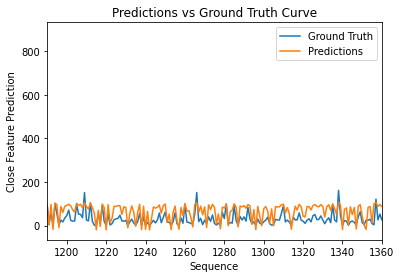

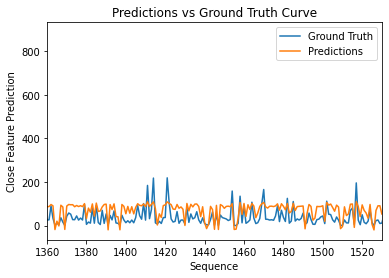

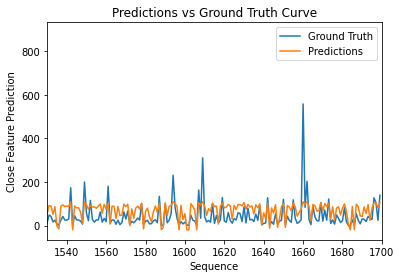

In [ ]:
model3.eval()
 
truevals = []
pred = []
iters = []

"""""
The following function compares the predictions of our model with the ground truth labels of the test set.
"""""
def get_testcost(model):

  count = 0

  for inp, label in test:
    if len(inp) > 0:
      count += 1
      v1 = torch.flatten(inp[0]).unsqueeze(0)
      v2 = torch.tensor(v1.unsqueeze(2), dtype=torch.float)
      output, _ = model(v2)
      pred.append(float(output))
      truevals.append(float(label))
      iters.append(count)


  plt.title("Predictions vs Ground Truth Curve")
  plt.plot(iters, truevals, label="Ground Truth")
  plt.plot(iters, pred, label="Predictions")
  plt.xlabel("Sequence")
  plt.ylabel("Close Feature Prediction")
  plt.legend(loc='best')
  plt.show()

  lim = 0
  for i in range(10):
    plt.title("Predictions vs Ground Truth Curve")
    plt.plot(iters, truevals, label="Ground Truth")
    plt.plot(iters, pred, label="Predictions")
    plt.xlabel("Sequence")
    plt.ylabel("Close Feature Prediction")
    plt.legend(loc='best')
    plt.xlim([lim, lim + 170])
    lim += 170
    plt.show()



get_testcost(model3)

  

Computed the closest ("most correct") prediction in comparison with ground truth

In [ ]:
for i in range(len(truevals)):
  if abs(truevals[i] - pred[i]) < 1:
    print(truevals[i], pred[i], i)
    print(abs(truevals[i] - pred[i]))
    print("\n")
   

103.3 103.12125396728516 0
0.1787460327148409


96.41 95.99547576904297 170
0.41452423095702784


3.5 4.364557266235352 298
0.8645572662353516


4.67 4.944619178771973 377
0.2746191787719727


12.64 12.927889823913574 407
0.28788982391357365


3.91 3.9494571685791016 526
0.03945716857910142


104.76 104.87962341308594 828
0.11962341308593238


101.45 101.5103530883789 908
0.06035308837890341


4.65 4.854091644287109 1011
0.20409164428710902


12.9 12.843536376953125 1065
0.056463623046875355


101.0 100.5049819946289 1074
0.49501800537109375


15.0 14.597397804260254 1182
0.4026021957397461


98.63 99.37718963623047 1189
0.7471896362304733


16.53 15.908927917480469 1250
0.6210720825195324


105.53 105.02574920654297 1668
0.5042507934570324


105.08 104.44143676757812 1696
0.6385632324218733




Computed the worst ("least correct") prediction in comparison with ground truth (an example of a prediction that was the least accurate)

In [ ]:
curr_highest = 0
curr_true = None
curr_pred = None
curr_i = None

for i in range(len(truevals)):

  if abs(truevals[i] - pred[i]) > curr_highest:
    curr_highest = abs(truevals[i] - pred[i])
    curr_true = truevals[i]
    curr_pred = pred[i]
    curr_i = i
  
print(curr_highest, curr_true, curr_pred, curr_i)

778.2845889282227 887.87 109.58541107177734 126
